Here i can write what happends in the cell below

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Read the data

In [2]:
df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')

# Step 2: Extract the text data (adjust column name to your CSV structure)
sentences = df['text'].tolist()


<>:1: SyntaxWarning: invalid escape sequence '\Q'
<>:1: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\gonor\AppData\Local\Temp\ipykernel_35088\3844972058.py:1: SyntaxWarning: invalid escape sequence '\Q'
  df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')


In [4]:
import pandas as pd
import csv
import re
import os

source_path = "data/QAQC_v1/swe_qaqc_train.csv"        # path to the source data, need to be downloaded ignored for git
output_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"   # set the same output path to not push data to git

# helper to remove outer quotation marks
def strip_outer_quotationmarks(q):
    if q.startswith('"') and q.endswith('"'):
        q = q[1:-1]  
    return q.strip()

# helper to remove commas in the question text, causes problems since the cols are set by commas in csv file
def replace_commas(line):
    pattern = r'"([^"]*?)"'
    def replace_commas(match):
        return '"' + match.group(1).replace(',', '|') + '"'
    return re.sub(pattern, replace_commas, line)

def process_csv(source_data_path, output_data_path, temp_file_path="temp_file.csv"):
    with open(source_data_path, 'r', encoding='utf-8') as infile:
        modified_lines = [replace_commas(line.strip()) for line in infile]

    with open(temp_file_path, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write('\n'.join(modified_lines))

    temp_data = pd.read_csv(temp_file_path, quoting=csv.QUOTE_NONE)  
    questions = temp_data["text"].tolist()
    no_comma_questions = [strip_outer_quotationmarks(q) for q in questions]

    coarse_labels = list(map(lambda x: x.split(":")[0], temp_data["verbose label"].tolist())) # only keep the coarse lable 
    zipped = list(zip(no_comma_questions, coarse_labels))

    with open(output_data_path, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["text", "coarse label"])
        writer.writerows(zipped)

    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)


    #print(f"Processed data saved to {output_data_path}") # trace print

# data formatted and ready for splitting 
_ = process_csv(source_path, output_path)

Data-split

Splits the formatted data into 80% local training data, 10% local test data and 10% remote user test data.

In [5]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['coarse label'])
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_data['coarse label'])
    
    local_train_data = train_data[['text']].copy()  # no need for the lable that wont be used as a lable
    
    local_test_data_for_eval = local_test_data[['text', 'coarse label']].copy()
    remote_test_data_for_eval = remote_test_data[['text', 'coarse label']].copy()
    
    local_train_file = os.path.join(split_path, "local_train.csv")
    local_test_file = os.path.join(split_path, "local_test.csv")
    remote_test_file = os.path.join(split_path, "remote_test.csv")
    
    local_train_data.to_csv(local_train_file, index=False, header=True)
    local_test_data_for_eval.to_csv(local_test_file, index=False, header=True)
    remote_test_data_for_eval.to_csv(remote_test_file, index=False, header=True)
    
    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v1/splits/"
data_split(source_path, split_path)


Data splits saved to: data/QAQC_v1/splits/


### Sentence Transformers (Gustav)

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danie\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-pack

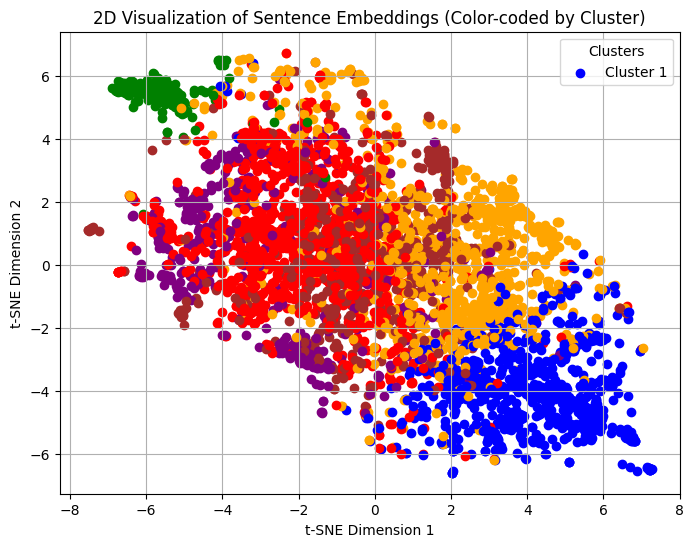

                                                text
0                                 Vad är stjärnfall?
1  Vad heter den lysande brittiska ekonomen bakom...
2  Vilken godbit efter middagen uppfanns 1916 på ...
3  Vilken fejd slutade med ett äktenskap i Kentuc...
4                Vad var målet för M3-tillväxt 1992?


In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Load sentences from the local training data
local_train_path = "data/QAQC_v1/splits/local_train.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 2: Use KMeans to cluster the embeddings into 6 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels for each embedding
cluster_labels = kmeans.labels_

# Step 3: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
}
colors = [color_map[label] for label in cluster_labels]

# Step 4: Apply t-SNE to reduce the embeddings to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 5: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

# Display the head of the DataFrame (local training data)
print(local_train_data.head())

### Tuples of sting and null

In [ ]:
# TEST
# Assuming you have already loaded local_train_data
# Create tuples of (text, None)
formatted_data = [(row['text'], None) for index, row in local_train_data.iterrows()]

# Display the first few tuples to verify the formatting
print(formatted_data[:5])  # Print the first 5 tuples


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 137/137 [00:07<00:00, 18.70it/s]
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


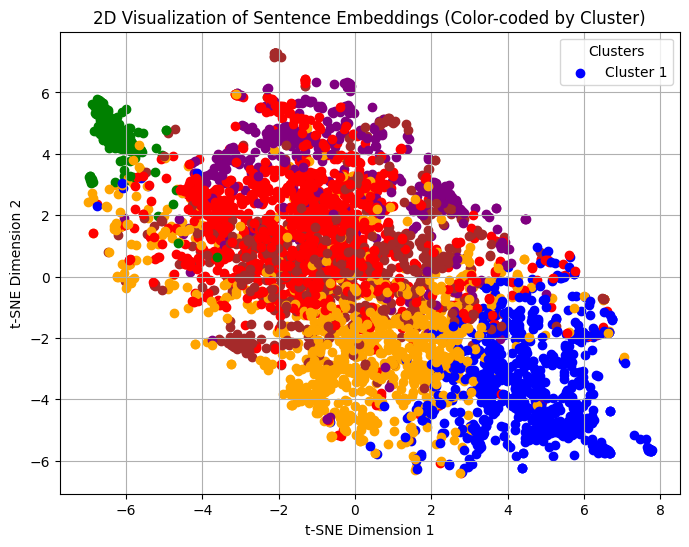

[('Vad är stjärnfall?', None), ('Vad heter den lysande brittiska ekonomen bakom skapandet?', None), ('Vilken godbit efter middagen uppfanns 1916 på George Jung-nudelfabriken i Los Angeles?', None), ('Vilken fejd slutade med ett äktenskap i Kentucky den 21 mars 1891?', None), ('Vad var målet för M3-tillväxt 1992?', None)]


In [4]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load sentences from the local training data
local_train_path = "data/QAQC_v1/splits/local_train.csv"
local_train_data = pd.read_csv(local_train_path)
sentences = local_train_data['text'].tolist()

# Step 1: Generate embeddings for the extracted sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 2: Use KMeans to cluster the embeddings into 6 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels for each embedding
cluster_labels = kmeans.labels_

# Step 3: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
}
colors = [color_map[label] for label in cluster_labels]

# Step 4: Apply t-SNE to reduce the embeddings to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 5: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

# Format input data to tuples
formatted_data = [(row['text'], None) for index, row in local_train_data.iterrows()]

# Display the first few tuples to verify the formatting
print(formatted_data[:5])  # Print the first 5 tuples


---
# SentenceTransformers (Jacob)

Testing pre trained model referenced on official page of SentenceTransformer

c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 171/171 [00:13<00:00, 12.39it/s]
c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


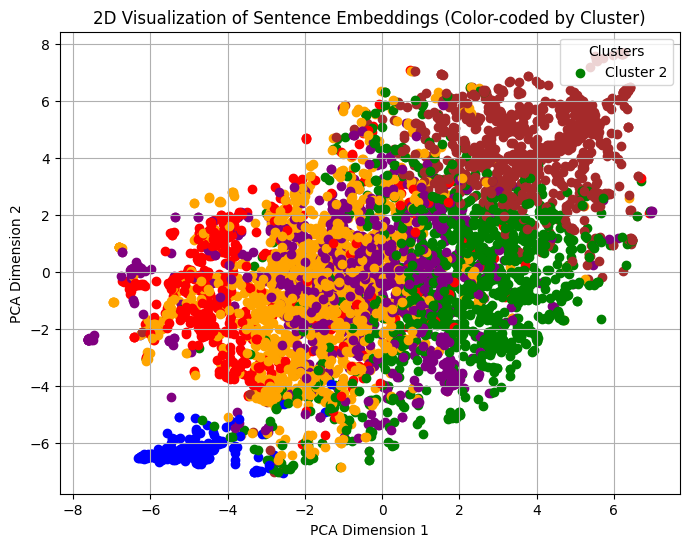

                                                text verbose label  \
0              Hur utvecklades träldomen i Ryssland?   DESC:manner   
1  Vilka filmer inkluderade karaktären Popeye Doyle?   ENTY:cremat   
2  Hur kan jag hitta en lista över kändisars rikt...   DESC:manner   
3  Vilken fjäderfä fångar rampljuset efter det ki...   ENTY:animal   
4            Vad är den fullständiga formen av .com?      ABBR:exp   

   coarse label  fine label  
0             2           4  
1             3           9  
2             2           4  
3             3           6  
4             4           1  


In [6]:



# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# # Load the CSV file into a DataFrame
# df = pd.read_csv('ML/swe_qaqc_train.csv')

# # Print the first 5 rows of the DataFrame to verify the contents
# print(df.head())
# # Load a pre-trained SBERT model
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # List of sentences to encode
# sentences = df['text'].tolist()

# # Get sentence embeddings
# embeddings = model.encode(sentences, show_progress_bar=True)
# # pca = PCA(n_components=2)
# # embedding_2d = pca.fit_transform(embeddings)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# embedding_2d = tsne.fit_transform(embeddings)


# # Print the embeddings
# #for sentence, embedding in zip(sentences, embeddings):
# #    print(f"Sentence: {sentence}")
# #    print(f"Embedding: {embedding[:1]}...")  # Print the first 5 dimensions of the embedding for brevity
# #    print()
# #print(f"Embedding dimensions: {len(embeddings[0])}")
# for i, (sentence, embedding) in enumerate(zip(sentences, embeddings)):
#     if i >= 10:
#         break  # Stop after printing 10 sentences
#     print(f"Sentence {i + 1}: {sentence}")
#     print(f"Embedding {i + 1} (first 5 dimensions): {embedding[:5]}\n")
# plt.figure(figsize=(8, 6))
# for i, sentence in enumerate(sentences):
#     plt.scatter(embedding_2d[i, 0], embedding_2d[i, 1])
#     #plt.text(embedding_2d[i, 0] + 0.01, embedding_2d[i, 1] + 0.01, sentence[:20], fontsize=9)  # Display the first 20 chars of the sentence

# plt.title("2D Visualization of Sentence Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.grid(True)
# plt.show()




# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# Step 1: Load the CSV file into a DataFrame (adjust path and column as needed)

# Step 3: Load a pre-trained SBERT model




# ##.\envISBIT\Scripts\activate to activate my virtual environment
# ## "deactivate" to deactivate it
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Step 4: Generate embeddings for the extracted sentences
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 5: Use KMeans to cluster the embeddings into 3 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels (0, 1, 2) for each embedding
cluster_labels = kmeans.labels_

# Step 6: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan'
}
colors = [color_map[label] for label in cluster_labels]

# Step 7: Apply PCA to reduce the embeddings to 2D for visualization
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 8: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")
    #plt.text(embedding[0] + 0.01, embedding[1] + 0.01, f"Point {i+1}", fontsize=9)


#
#inputdata ska vara en tuple med (string, label), där label=NIL om den inte assignats än. 
#forloop:
#   inputdata=modification(inputdata)  //modification ska kolla på en del av tuplerna, säg ("Hur utvecklades träldomen i Ryssland?",NIL) och omvandla den till ("Hur utvecklades träldomen i Ryssland?",DESC)
#   LabelPropagation(inputData)
#

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()
print(df.head())



In [4]:
print(sentences[1:19])

['Vilka filmer inkluderade karaktären Popeye Doyle?', 'Hur kan jag hitta en lista över kändisars riktiga namn?', 'Vilken fjäderfä fångar rampljuset efter det kinesiska apans år?', 'Vad är den fullständiga formen av .com?', 'Vilken föraktlig skurk stal korken från min lunch?', 'Vilket lag blev basebollens St. Louis Browns?', 'Vad är det äldsta yrket?', 'Vad är leverenzymer?', 'Namnge den ärriga prisjägaren i The Old West.', 'När föddes Ozzy Osbourne?', 'Varför faller tyngre föremål snabbare nedåt?', 'Vem var Yankees stolthet?', 'Vem dödade Gandhi?', 'Vad anses vara den dyraste katastrofen som försäkringsbranschen någonsin har stött på?', 'Vilken utbredd amerikansk stat har flest flygplatser?', 'Vad behandlade den enda upphävda ändringen av USA:s konstitution?', 'Hur många judar avrättades i koncentrationsläger under andra världskriget?', 'Vad är Nine Inch Nails"?"']
